# 金融数据分析期末作业 

谢慧琴 合肥MF1班 SA19204118

#注意：需要用Excel删除citics表格股票代码后缀.SH和.SZ

In [1]:
import pandas as pd
import numpy as np
#import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## 1 定义需要用到的函数

In [2]:
def net_return1_3(group,df_cut,df):
    #在每月调仓的情况下，计算多/空组合收益率,适用于第一问和第三问。
    group_return=df[df_cut==group].groupby('日期').mean()[['净值收益率']].iloc[:-1,:]
    group_return.rename(columns={'净值收益率':'组合净值收益率'},inplace=True) 
    return group_return

In [3]:
def droplevel(df_cut,n):
    #为带有多重索引降级的df_cut降低索引级别，降级n次。
    for i in range(n):
        df_cut.index=df_cut.index.droplevel(level=0)
    return df_cut

In [4]:
def plot_value(long,short,diff):
    #计算绘图所需的多头组合净值、空头组合净值、多空双方收益率之差的累计值
    long=long.shift(1).fillna(0).cumsum()+1
    short=short.shift(1).fillna(0).cumsum()+1
    diff=diff.shift(1).fillna(0)
    return (long,short,diff)

In [5]:
def return_difference(df_long,df_short):
    #对多头组合与空头组合每月净值收益率之差进行累计
    difference=df_long-df_short
    difference['累计多空组合净值收益率之差']=difference['组合净值收益率'].cumsum() 
    difference.rename(columns={'组合净值收益率':'组合净值收益率之差'},inplace=True)
    return difference

In [8]:
def net_return2(group,col_1,col_2,df,df_cut):
    #计算第二问的组合净值收益率
    cut_group=df_cut[df_cut == group]
    net_return2=df.loc[list(cut_group.index),:].groupby('日期').mean()[[col_1]].iloc[:-1,:]
    net_return2.rename(columns={col_1:col_2},inplace=True) 
    return net_return2

In [9]:
def industry_cut(df,n):
    '''
   在各个行业内部，每月按照Momentum对df经行分割，分成n等分，将前1/n，中间部分，
后1/n分别设置标签：max、mid、min。
    '''
    industry_cut=df.groupby(['日期','中信一级行业'])\
         .apply(lambda x: pd.qcut(x['Momentum'],q=[0,1/n,(1-1/n),1],labels=['min','mid','max']))
    return industry_cut

In [10]:
def wash_data1(df):
    #应用与第三问，去除在所考察的时间段内没有一直存在的股票，如由于退市、数据缺失、新进入市场等。
    temp=df.groupby(['股票代码']).apply(pd.DataFrame.count)
    codelist=list(temp.index[temp['日期']==max(temp['日期'])])
    washed_data=df[df['股票代码'].apply(lambda x: x in codelist)]
    return washed_data 

## 2 问题前处理

### 2.1 处理原始数据

In [11]:
#导入csv文件
barra = pd.read_csv('barra.csv',encoding = "gbk")[['日期','股票代码','Momentum']]
citics = pd.read_csv('citics.csv',encoding = "gbk")
price = pd.read_csv('price.csv',encoding = "gbk")[['日期','股票代码','复权收盘价']]

In [12]:
#规范原始DataFrame的格式
barra['日期']=pd.to_datetime(barra.iloc[:,0],format="%Y%m%d")
price['日期']=pd.to_datetime(price.iloc[:,0],format="%Y%m%d")
barra['股票代码']=barra['股票代码'].astype(str).str.zfill(6)
price['股票代码']=price['股票代码'].astype(str).str.zfill(6)
#用Excel删除股票代码后缀.SH和.SZ
citics['股票代码']=citics['股票代码'].astype(str).str.zfill(6)

In [13]:
#排序
barra=barra.sort_values(['日期','股票代码'],axis = 0,ascending = True)
price=price.sort_values(['日期','股票代码'],axis = 0,ascending = True)
citics=citics.sort_values(['股票代码'],axis = 0,ascending = True)

### 2.2 合并处理之后的原始数据

In [14]:
raw_data=pd.merge(price.merge(barra, on=['日期', '股票代码']),citics,on = ["股票代码"],how = "inner")

In [15]:
#raw_data：合并后的DataFrame
raw_data

,日期,股票代码,复权收盘价,Momentum,中信一级行业
0,2009-12-31,000001,875.02,0.326747,银行
1,2010-01-29,000001,779.15,0.308905,银行
2,2010-02-26,000001,806.08,0.149440,银行
3,2010-03-31,000001,833.01,0.035006,银行
4,2010-04-30,000001,738.22,0.081177,银行
5,2010-05-31,000001,628.71,-0.161698,银行
6,2010-06-30,000001,628.71,-0.404250,银行
7,2010-07-30,000001,628.71,-0.027122,银行
8,2010-08-31,000001,628.71,-0.694170,银行
9,2010-09-30,000001,582.39,-0.696395,银行


### 2.3 数据清洗

In [16]:
#washed_data： 清洗之后的数据
#重复值处理
raw_data.drop_duplicates()
#缺失值处理
raw_data.dropna(axis=0)
washed_data=raw_data

### 2.4 计算每月净值收益率

In [17]:
#yield_data：新增了净值收益率这一列的DataFrame
close_price=washed_data['复权收盘价']
log_change=close_price/close_price.shift(1)-1
#注意：净值收益率整体向上移动一个位置，如第0行的净值收益率-0.109563本质上是2010年1月的净值收益率。
#该步骤目的是为后续根据上月Momentum调节仓位，再基于调节了的仓位计算本月多空组合净值收益率提供方便。
washed_data['净值收益率']=log_change.shift(-1)
yield_data=washed_data
yield_data

,日期,股票代码,复权收盘价,Momentum,中信一级行业,净值收益率
0,2009-12-31,000001,875.02,0.326747,银行,-0.109563
1,2010-01-29,000001,779.15,0.308905,银行,0.034563
2,2010-02-26,000001,806.08,0.149440,银行,0.033409
3,2010-03-31,000001,833.01,0.035006,银行,-0.113792
4,2010-04-30,000001,738.22,0.081177,银行,-0.148343
5,2010-05-31,000001,628.71,-0.161698,银行,0.000000
6,2010-06-30,000001,628.71,-0.404250,银行,0.000000
7,2010-07-30,000001,628.71,-0.027122,银行,0.000000
8,2010-08-31,000001,628.71,-0.694170,银行,-0.073675
9,2010-09-30,000001,582.39,-0.696395,银行,0.135013


## 3 第一问的数值计算

### 3.1 获得每月多空组合


In [18]:
#按日期分组，在组内切分成max、mid、min三组。
#date_cut：分组结果
date_cut=yield_data.groupby(['日期'])\
     .apply(lambda x: pd.qcut(x['Momentum'],q=[0,1/5,(1-1/5),1],labels=['min','mid','max']))
date_cut

日期                
2009-12-31  0         mid
            103       min
            206       mid
            309       max
            412       mid
            515       mid
            618       mid
            721       mid
            824       mid
            927       mid
            1030      mid
            1133      mid
            1236      max
            1339      min
            1442      mid
            1545      mid
            1648      max
            1751      mid
            1854      min
            1957      max
            2060      max
            2163      mid
            2266      min
            2369      mid
            2472      mid
            2575      max
            2678      mid
            2781      mid
            2884      max
            2987      mid
                     ... 
2018-06-29  263329    max
            263333    max
            263337    max
            263340    max
            263343    max
            263346    max
            263349 

In [19]:
#对date_cut的多重索引降级
date_cut=droplevel(df_cut=date_cut,n=1)

### 3.2 计算多空组合收益率的累计组合收益率差值

In [20]:
#计算多空组合净值收益率
long_net_return=net_return1_3(group='max',df_cut=date_cut,df=yield_data)
short_net_return=net_return1_3(group='min',df_cut=date_cut,df=yield_data)

D:\software\anaconda\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [21]:
#将多头组合与空头组合每月净值收益率之差进行累计。
difference=return_difference(long_net_return,short_net_return)

### 3.3 处理3.2数据，得到第一问最终结果

In [22]:
#处理原始收益率数据，得到以1为起点的多空组合净值和处理后累计多空组合净值收益率之差。
(long_net_return_plot,short_net_return_plot,difference_plot)=\
    plot_value(long=long_net_return,short=short_net_return,diff=difference)
long_net_return_plot.rename(columns={'组合净值收益率':'多头组合净值'},inplace=True)
short_net_return_plot.rename(columns={'组合净值收益率':'空头组合净值'},inplace=True)

## 4 第二问的数值计算

### 4.1 形成行业内的多头与空头组合

In [23]:
#获得行业内的多空组合分组
industry_cut=industry_cut(df=yield_data,n=5)
industry_cut

日期          中信一级行业        
2009-12-31  交通运输    1854      mid
                    5665      mid
                    5768      min
                    6077      mid
                    9457      mid
                    10384     mid
                    11403     min
                    14567     mid
                    16318     mid
                    33304     mid
                    36474     max
                    37607     max
                    38019     min
                    49644     max
                    57871     mid
                    64360     mid
                    67141     max
                    70746     max
                    78780     max
                    80531     min
                    80943     min
                    81252     mid
                    81561     mid
                    81664     mid
                    81870     mid
                    82179     min
                    82488     mid
                    82797     mid
                    8

In [24]:
industry_cut=droplevel(df_cut=industry_cut,n=2)

### 4.2 计算多空组合收益率的累计组合收益率差值

In [25]:
long_net_return2=net_return2('max','净值收益率','组合净值收益率',df=yield_data,df_cut=industry_cut)
short_net_return2=net_return2('min','净值收益率','组合净值收益率',df=yield_data,df_cut=industry_cut)

In [26]:
difference2=return_difference(long_net_return2,short_net_return2)

### 4.3 处理4.2数据，得到第二问最终结果

In [27]:
(long_net_return_plot2,short_net_return_plot2,difference_plot2)=\
    plot_value(long=long_net_return2,short=short_net_return2,diff=difference2)
long_net_return_plot2.rename(columns={'组合净值收益率':'多头组合净值'},inplace=True)
short_net_return_plot2.rename(columns={'组合净值收益率':'空头组合净值'},inplace=True)

## 5 第三问的数值计算

### 5.1 剔除银行业以及股票数小于60的行业

In [28]:
#季度调仓还未实现
    nobank=yield_data.loc[yield_data['中信一级行业'] != "银行"]
temp_indsum=citics.groupby('中信一级行业').count()
indu_list=list(temp_indsum[temp_indsum['股票代码']>=60].index)
num_over60_nobank=nobank.set_index("中信一级行业").loc[indu_list,:].reset_index()

In [29]:
#num_over60_nobank：剔除银行业以及股票数小于60的行业的数据
num_over60_nobank

,中信一级行业,日期,股票代码,复权收盘价,Momentum,净值收益率
0,交通运输,2009-12-31,000022,48.42,-0.461156,0.006609
1,交通运输,2010-01-29,000022,48.74,-0.413642,0.024210
2,交通运输,2010-02-26,000022,49.92,-0.075032,0.030248
3,交通运输,2010-03-31,000022,51.43,-0.044243,-0.119580
4,交通运输,2010-04-30,000022,45.28,0.028434,-0.117933
5,交通运输,2010-05-31,000022,39.94,-0.264330,-0.075363
6,交通运输,2010-06-30,000022,36.93,-0.351246,0.130788
7,交通运输,2010-07-30,000022,41.76,-0.403285,0.120929
8,交通运输,2010-08-31,000022,46.81,-0.391377,-0.051698
9,交通运输,2010-09-30,000022,44.39,0.118883,0.097319


In [30]:
#去除在研究期限期间没有一直存在的股票，如退市、中途上市的股票，防止之后季度调仓出现错误。
num_over60_nobank=wash_data1(num_over60_nobank)

### 5.2 构造每季度末调仓的每月多/空组合

In [31]:
industry_cut3=num_over60_nobank.groupby(['日期','中信一级行业'])\
     .apply(lambda x: pd.qcut(x['Momentum'],q=[0,1/10,(1-1/10),1],labels=['min','mid','max']))
industry_cut3

日期          中信一级行业        
2009-12-31  交通运输    0         mid
                    103       mid
                    206       mid
                    309       mid
                    412       mid
                    515       mid
                    706       mid
                    809       mid
                    912       mid
                    1015      mid
                    1118      mid
                    1221      mid
                    1324      mid
                    1427      mid
                    1530      mid
                    1633      mid
                    1736      max
                    1839      max
                    1942      min
                    2045      min
                    2148      mid
                    2251      mid
                    2354      mid
                    2457      mid
                    2560      min
                    2663      mid
                    2766      mid
                    2869      mid
                    2

In [32]:
#对industry_cut3的多重索引降级
industry_cut3=droplevel(df_cut=industry_cut3,n=2)

In [33]:
#max_min：将qcut所得的分组结果转换成的DataFrame
max_min=pd.DataFrame(industry_cut3)
max_min.rename(columns={'Momentum':'分组'},inplace=True)
max_min

,分组
0,mid
103,mid
206,mid
309,mid
412,mid
515,mid
706,mid
809,mid
912,mid
1015,mid


In [34]:
#为num_over60_nobank新增分组列，得到group_data
group_data=num_over60_nobank.join(max_min)
group_data

,中信一级行业,日期,股票代码,复权收盘价,Momentum,净值收益率,分组
0,交通运输,2009-12-31,000022,48.42,-0.461156,0.006609,mid
1,交通运输,2010-01-29,000022,48.74,-0.413642,0.024210,mid
2,交通运输,2010-02-26,000022,49.92,-0.075032,0.030248,mid
3,交通运输,2010-03-31,000022,51.43,-0.044243,-0.119580,mid
4,交通运输,2010-04-30,000022,45.28,0.028434,-0.117933,mid
5,交通运输,2010-05-31,000022,39.94,-0.264330,-0.075363,mid
6,交通运输,2010-06-30,000022,36.93,-0.351246,0.130788,mid
7,交通运输,2010-07-30,000022,41.76,-0.403285,0.120929,mid
8,交通运输,2010-08-31,000022,46.81,-0.391377,-0.051698,mid
9,交通运输,2010-09-30,000022,44.39,0.118883,0.097319,mid


In [35]:
#删除group_data中所有2018-06-29的记录，那么每只股票都恰好有34个月的记录
#结果记作group_data_del
group_data_del=group_data.drop(group_data[group_data['日期'] == '2018-06-29'].index)

In [36]:
#获得根据季度末的截面数调仓之后的每月多空组合 
group_list=list(group_data_del['分组'])
for i in range(len(group_list)):
    if i%3==0:
        group_list[i+1]=group_list[i]
        group_list[i+2]=group_list[i]
    else:
        pass
#修改原group_data_del的index
group_data_del.index = range(len(group_data_del))
group_data_del['分组']=pd.DataFrame(group_list)
quarter_data=group_data_del

In [37]:
#quarter_data：按季度调仓之后的多空组合
quarter_data

,中信一级行业,日期,股票代码,复权收盘价,Momentum,净值收益率,分组
0,交通运输,2009-12-31,000022,48.42,-0.461156,0.006609,mid
1,交通运输,2010-01-29,000022,48.74,-0.413642,0.024210,mid
2,交通运输,2010-02-26,000022,49.92,-0.075032,0.030248,mid
3,交通运输,2010-03-31,000022,51.43,-0.044243,-0.119580,mid
4,交通运输,2010-04-30,000022,45.28,0.028434,-0.117933,mid
5,交通运输,2010-05-31,000022,39.94,-0.264330,-0.075363,mid
6,交通运输,2010-06-30,000022,36.93,-0.351246,0.130788,mid
7,交通运输,2010-07-30,000022,41.76,-0.403285,0.120929,mid
8,交通运输,2010-08-31,000022,46.81,-0.391377,-0.051698,mid
9,交通运输,2010-09-30,000022,44.39,0.118883,0.097319,mid


### 5.3 计算多空组合收益率的累计组合收益率差值

In [38]:
long_net_return3=net_return1_3(group='max',df_cut=quarter_data['分组'],df=quarter_data)
short_net_return3=net_return1_3(group='min',df_cut=quarter_data['分组'],df=quarter_data)

In [39]:
difference3=return_difference(long_net_return3,short_net_return3)

### 5.4 处理4.2数据，得到第三问最终结果

In [40]:
(long_net_return_plot3,short_net_return_plot3,difference_plot3)=\
    plot_value(long=long_net_return3,short=short_net_return3,diff=difference3)
long_net_return_plot3.rename(columns={'组合净值收益率':'多头组合净值'},inplace=True)
short_net_return_plot3.rename(columns={'组合净值收益率':'空头组合净值'},inplace=True)

## 6 结果汇总

### 6.1 第一问结果

In [41]:
long_net_return_plot.join(short_net_return_plot).join(difference_plot)

,多头组合净值,空头组合净值,组合净值收益率之差,累计多空组合净值收益率之差
日期,,,,
2009-12-31,1.000000,1.000000,0.000000,0.000000
2010-01-29,0.955307,0.967268,-0.011961,-0.011961
2010-02-26,1.013581,1.031164,-0.005622,-0.017583
2010-03-31,1.061412,1.072087,0.006907,-0.010676
2010-04-30,0.996203,0.989998,0.016881,0.006205
2010-05-31,0.955018,0.886982,0.061831,0.068036
2010-06-30,0.849145,0.804997,-0.023888,0.044148
2010-07-30,0.968660,0.980897,-0.056385,-0.012237
2010-08-31,1.090473,1.029597,0.073112,0.060876


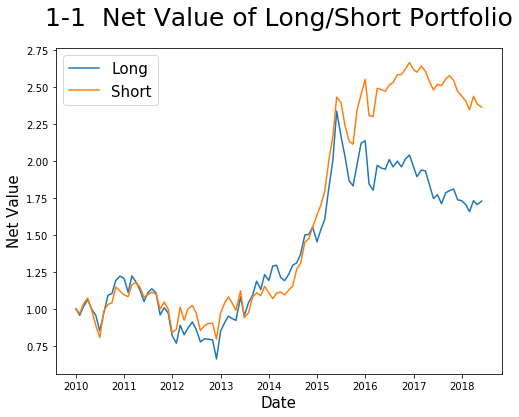

In [42]:
#1-1 市值因子的多空组合净值曲线
x=short_net_return.index
y1=long_net_return_plot
y2=short_net_return_plot
plt.subplots(figsize=(8,6))
plt.plot(x, y1,  label='sinx')
plt.plot(x, y2, label='cosx')
plt.xlabel('Date',size=15)
plt.ylabel('Net Value',size=15)
plt.title('1-1  Net Value of Long/Short Portfolio',size=25,y=1.05)
plt.legend(labels=['Long','Short'],loc='upper left',fontsize=15)
plt.show()

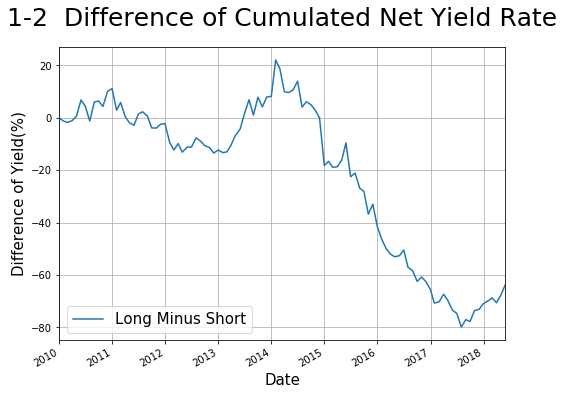

In [43]:
# 1-2 累加多空组合净值收益率之差
difference_plot[['累计多空组合净值收益率之差']].apply(lambda x:x*100).plot(figsize=(8,6),secondary_y='close',grid=True)
plt.xlabel('Date',size=15)
plt.ylabel('Difference of Yield(%)',size=15)
plt.title('1-2  Difference of Cumulated Net Yield Rate',size=25,y=1.05)
plt.legend(labels=['Long Minus Short'],loc='lower left',fontsize=15)
plt.show()

## 6.2 第二问结果

In [44]:
long_net_return_plot2.join(short_net_return_plot2).join(difference_plot2)

,多头组合净值,空头组合净值,组合净值收益率之差,累计多空组合净值收益率之差
日期,,,,
2009-12-31,1.000000,1.000000,0.000000,0.000000
2010-01-29,0.956347,0.976036,-0.019689,-0.019689
2010-02-26,1.018636,1.045289,-0.006965,-0.026654
2010-03-31,1.060326,1.087002,-0.000022,-0.026676
2010-04-30,0.994070,1.014360,0.006385,-0.020290
2010-05-31,0.948238,0.917353,0.051176,0.030885
2010-06-30,0.845187,0.836401,-0.022100,0.008786
2010-07-30,0.975665,0.998780,-0.031900,-0.023115
2010-08-31,1.081174,1.064209,0.040079,0.016965


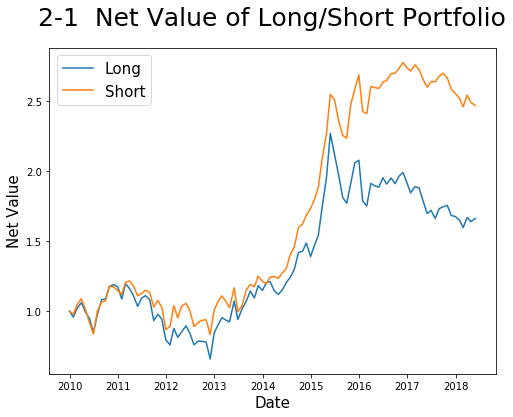

In [45]:
# 2-1 市值因子在行业中性条件下的多空组合净值曲线
x=long_net_return_plot2.index
y1=long_net_return_plot2
y2=short_net_return_plot2
plt.subplots(figsize=(8,6))
plt.plot(x, y1,  label='sinx')
plt.plot(x, y2, label='cosx')
plt.xlabel('Date',size=15)
plt.ylabel('Net Value',size=15)
plt.title('2-1  Net Value of Long/Short Portfolio',size=25,y=1.05)
plt.legend(labels=['Long','Short'],loc='upper left',fontsize=15)
plt.show()

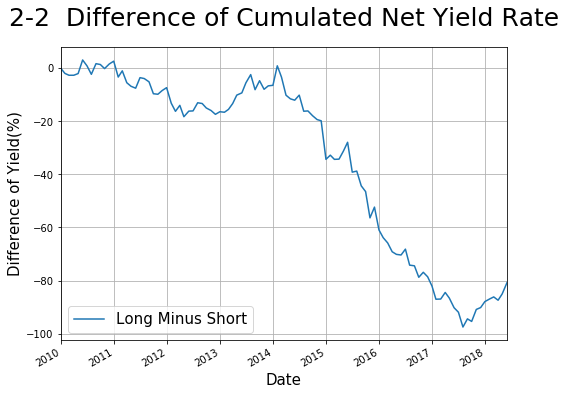

In [46]:
difference_plot2[['累计多空组合净值收益率之差']].apply(lambda x:x*100).plot(figsize=(8,6),secondary_y='close',grid=True)
plt.xlabel('Date',size=15)
plt.ylabel('Difference of Yield(%)',size=15)
plt.title('2-2  Difference of Cumulated Net Yield Rate',size=25,y=1.05)
plt.legend(labels=['Long Minus Short'],loc='lower left',fontsize=15)
plt.show()

## 6.3 第三问结果

In [47]:
long_net_return_plot3.join(short_net_return_plot3).join(difference_plot3)

,多头组合净值,空头组合净值,组合净值收益率之差,累计多空组合净值收益率之差
日期,,,,
2009-12-31,1.000000,1.000000,0.000000,0.000000
2010-01-29,0.942338,0.979528,-0.037190,-0.037190
2010-02-26,1.005772,1.036032,0.006930,-0.030260
2010-03-31,1.068850,1.076198,0.022912,-0.007348
2010-04-30,0.990925,1.007004,-0.008731,-0.016079
2010-05-31,0.946350,0.906362,0.056067,0.039988
2010-06-30,0.854520,0.805486,0.009046,0.049034
2010-07-30,0.983466,0.981917,-0.047485,0.001549
2010-08-31,1.092031,1.042659,0.047823,0.049372


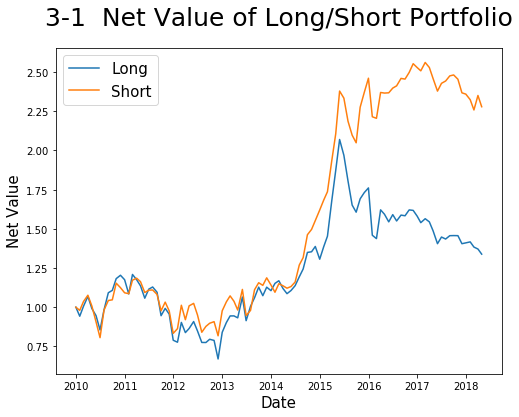

In [48]:
#3-1 季度调仓下，市值因子在行业中性条件下的多空组合净值曲线
x=long_net_return_plot3.index
y1=long_net_return_plot3
y2=short_net_return_plot3
plt.subplots(figsize=(8,6))
plt.plot(x, y1,  label='sinx')
plt.plot(x, y2, label='cosx')
plt.xlabel('Date',size=15)
plt.ylabel('Net Value',size=15)
plt.title('3-1  Net Value of Long/Short Portfolio',size=25,y=1.05)
plt.legend(labels=['Long','Short'],loc='upper left',fontsize=15)
plt.show()

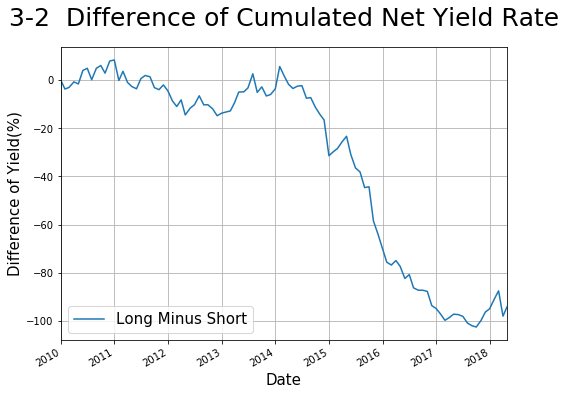

In [49]:
difference_plot3[['累计多空组合净值收益率之差']].apply(lambda x:x*100).plot(figsize=(8,6),secondary_y='close',grid=True)
plt.xlabel('Date',size=15)
plt.ylabel('Difference of Yield(%)',size=15)
plt.title('3-2  Difference of Cumulated Net Yield Rate',size=25,y=1.05)
plt.legend(labels=['Long Minus Short'],loc='lower left',fontsize=15)
plt.show()

## 7 结论

    Momentum因子在全市场的动量因子多空因子组合，行业中性的动量因子多空组合和每季度调仓的构建投资约束下的行业中性的动量因子非银多空组合中表现大基本相同。由净值曲线可以看出，在2010年到2014年，多空组合净值趋于一致平稳状态。2014年到2016年，多/空组合净值曲线呈现一致上升趋势。而2016年到2018年，空头组合净值曲线显著高于多头组合。
    如若持续交易，由累计多空组合净值收益率之差曲线，我们可以看出。累计多空组合净值收益率之差在2010年到2014年间趋于平稳（在0%附近波动），而后在2014年到2017年间呈现持续下跌趋势，到了2017年之后，累计多空组合净值收益率之差稳定在接近-100%位置。
    